In [1]:
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

enable_grid = False

In [2]:
!pip install pyspark

In [3]:
#downloading Data

def download_files(urlprefix='',filenames=[],download_location=''):
    import urllib
    from pathlib import Path
    from os import path
    Path(download_location).mkdir(parents=True, exist_ok=True)
    for x in filenames:
        if not path.exists(path.join(download_location,x)):
            print(f'downloading and saving file {x} at {download_location}')
            urllib.request.urlretrieve(urlprefix+x,path.join(download_location,x))
            if path.exists(download_location+x):
                print(f'downloaded {x}')
        else:
            print(f'already exists {x} at {download_location+x}')

In [4]:
from urllib import request
csv_location = './data/fire'
download_files(filenames=['forestfires.csv'],urlprefix="http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/",download_location=csv_location)

already exists forestfires.csv at ./data/fireforestfires.csv


In [5]:
# importing spark
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
conf  = SparkConf()\
#         .set("spark.driver.maxResultSize", "3g")\
#         .set("spark.executor.cores",4)\
#         .set('spark.memory.fraction',0.8)\
#         .set('spark.executer.memory',"12g")\
#         .set('spark.driver.memory','15g')\
#         .set("spark.memory.offHeap.enabled",'true')\
#         .set("spark.memory.offHeap.size","12g")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

In [6]:
#loading data
df = spark.read.csv(csv_location,header=True,inferSchema=True)
df.limit(5).toPandas()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
print(f'shape {df.count()} x {len(df.columns)}')

shape 517 x 13


In [8]:
df.printSchema()

root
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- FFMC: double (nullable = true)
 |-- DMC: double (nullable = true)
 |-- DC: double (nullable = true)
 |-- ISI: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- wind: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- area: double (nullable = true)



In [9]:
# changing x and y to double
from pyspark.sql import functions as F
import pyspark.sql.types as T

df = df.withColumn('X',F.col('X').cast(T.DoubleType()))
df = df.withColumn('Y',F.col('Y').cast(T.DoubleType()))

In [10]:
df.summary().toPandas().T

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
X,517,4.669245647969052,2.313777828725767,1.0,3.0,4.0,7.0,9.0
Y,517,4.299806576402321,1.22990040298981,2.0,4.0,4.0,5.0,9.0
month,517,None,None,apr,None,None,None,sep
day,517,None,None,fri,None,None,None,wed
FFMC,517,90.6446808510636,5.520110848851271,18.7,90.2,91.6,92.9,96.2
DMC,517,110.87234042553195,64.04648224925424,1.1,68.6,108.3,142.4,291.3
DC,517,547.9400386847191,248.06619170584355,7.9,437.7,664.2,713.9,860.6
ISI,517,9.021663442940042,4.559477175216039,0.0,6.5,8.4,10.8,56.1
temp,517,18.88916827852998,5.806625349573504,2.2,15.5,19.3,22.8,33.3


In [11]:
# finding null values
from pyspark.sql import functions as F

df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# anlysis
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [13]:
df.select('month').distinct().collect()

[Row(month='jun'),
 Row(month='aug'),
 Row(month='may'),
 Row(month='feb'),
 Row(month='sep'),
 Row(month='mar'),
 Row(month='oct'),
 Row(month='jul'),
 Row(month='nov'),
 Row(month='apr'),
 Row(month='dec'),
 Row(month='jan')]

In [14]:
#univariate analysis
import pyspark.sql.types as T
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,
             'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,
             'nov':11,'dec':12}

month_mapper = F.udf(lambda x:month_map[x],T.IntegerType()) 
df = df.withColumn('no_months',month_mapper(F.col('month')))

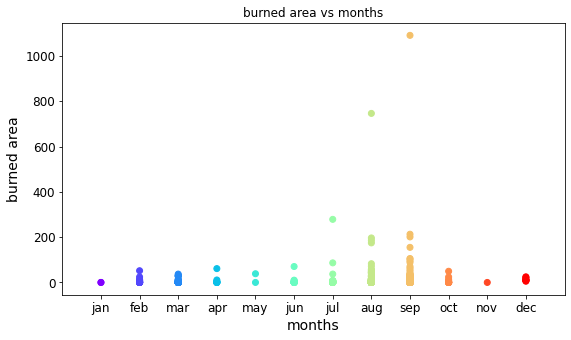

In [15]:
# area vs month plot
import numpy as np

df_month_area = df.select(['month','area','no_months']).toPandas()
plt.figure(figsize=(9,5))
plt.scatter(df_month_area['no_months'],df_month_area['area'],cmap='rainbow',
            c=df_month_area['no_months'])
plt.xlabel('months')
plt.xlim(0,13)
plt.ylabel('burned area')
plt.title('burned area vs months')
plt.xticks(range(1,13,1),month_map.keys())
plt.show()

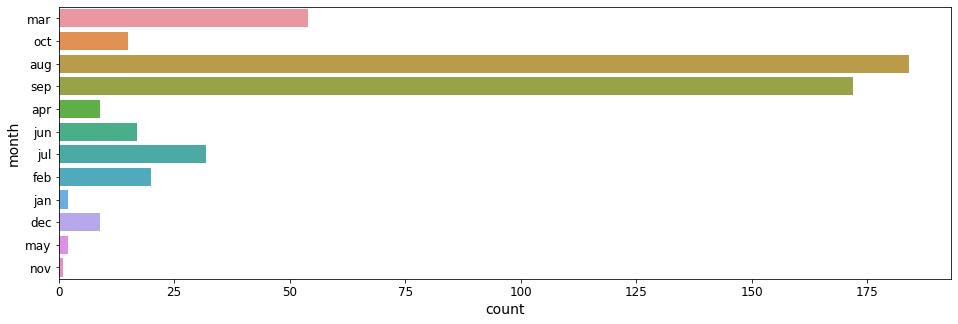

In [16]:
import seaborn as sns
plt.figure(figsize=(16,5))
sns.countplot(data=df_month_area,y='month')
plt.show()

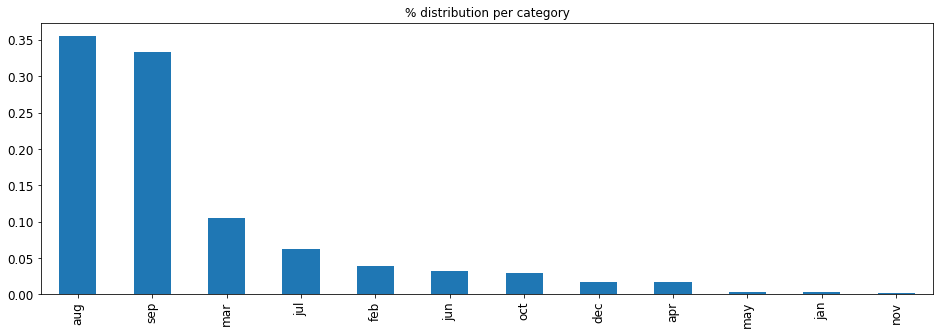

In [17]:
plt.figure(figsize=(16,5))
df_month_area['month'].value_counts(normalize=True).plot.bar()
plt.title('% distribution per category')
plt.show()

+------------------+-----------------+
|    skewness(area)|   kurtosis(area)|
+------------------+-----------------+
|12.809629951754554|192.2566455690249|
+------------------+-----------------+



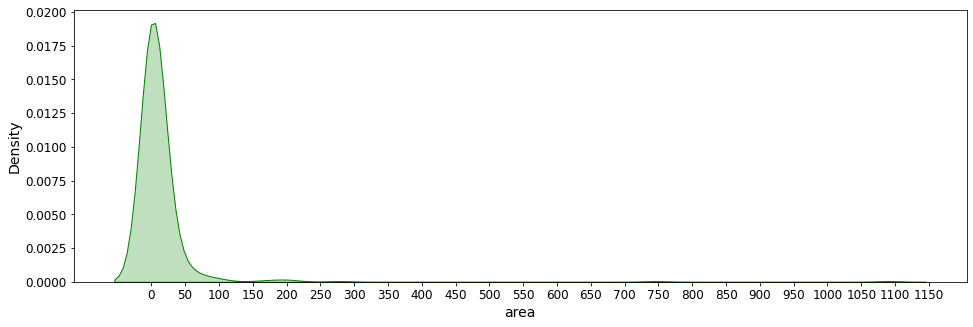

In [18]:
df.select(F.skewness('area'),F.kurtosis('area')).show()

plt.figure(figsize=(16,5))
ax = sns.kdeplot(df_month_area['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

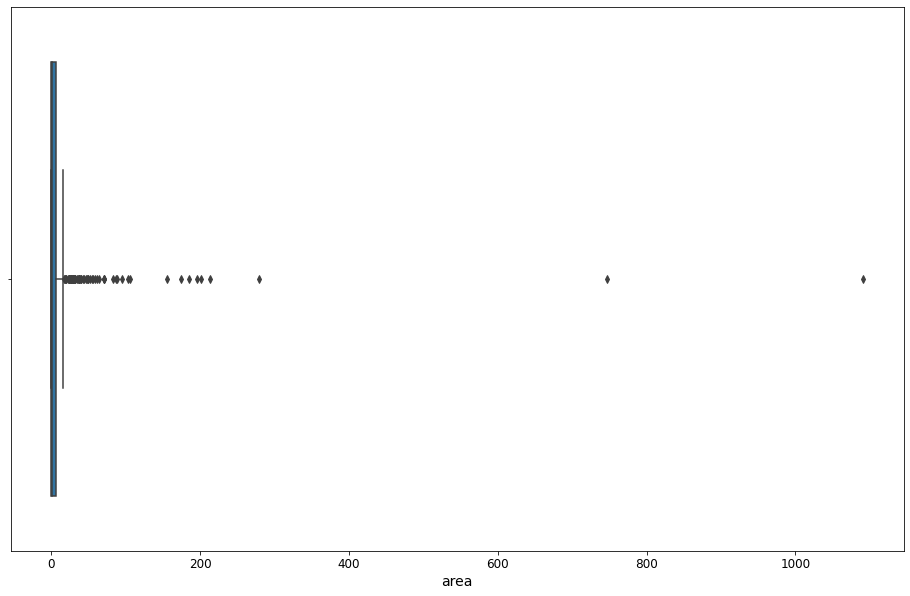

In [19]:
plt.figure(figsize=(16,10))
sns.boxplot(x=df_month_area['area'])
plt.show()

In [20]:
df.select('day').distinct().show()

+---+
|day|
+---+
|fri|
|thu|
|tue|
|sat|
|wed|
|mon|
|sun|
+---+



In [21]:
day_map = {'sun':1,'mon':2,'tue':3,'wed':4,'thu':5,'fri':6,'sat':7}
day_mapper = F.udf(lambda x:day_map[x],T.IntegerType())

df = df.withColumn('day_no',day_mapper(F.col('day')))

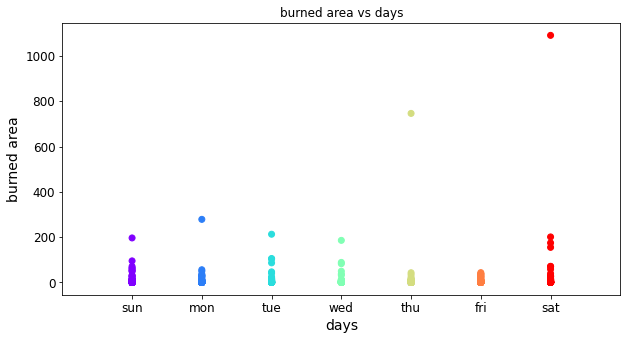

In [22]:
df_day_area = df.select(['day','area','day_no']).toPandas()
plt.figure(figsize=(10,5))
plt.scatter(df_day_area['day_no'],df_day_area['area'],cmap='rainbow',
            c=df_day_area['day_no'])
plt.xlabel('days')
plt.xlim(0,8)
plt.ylabel('burned area')
plt.title('burned area vs days')
plt.xticks(range(1,8,1),day_map.keys())
plt.show()

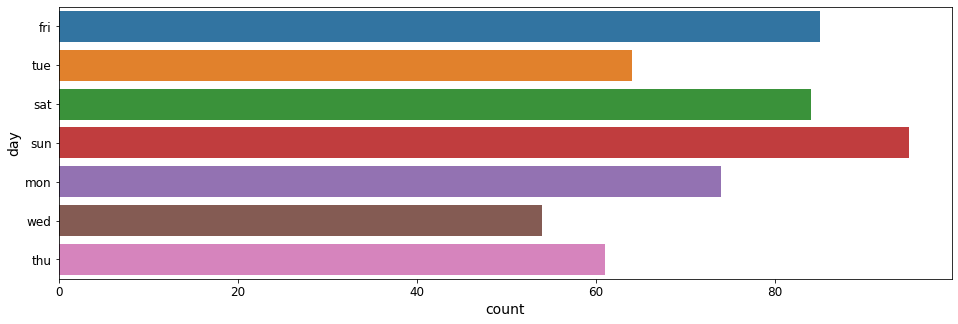

In [23]:
plt.figure(figsize=(16,5))
sns.countplot(data=df_day_area,y='day')
plt.show()

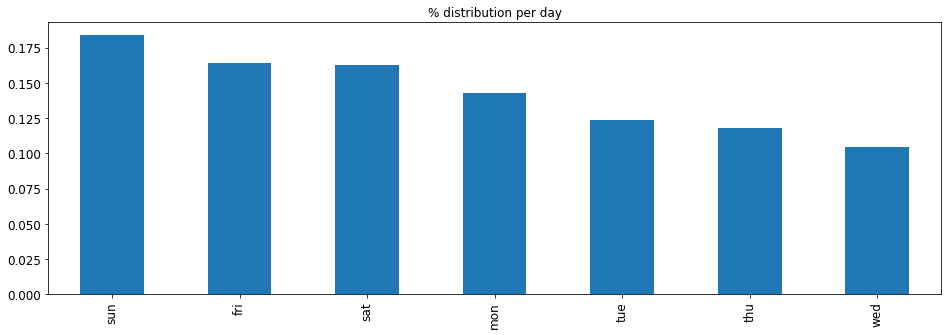

In [24]:
plt.figure(figsize=(16,5))
df_day_area['day'].value_counts(normalize=True).plot.bar()
plt.title('% distribution per day')
plt.show()

In [25]:
df.columns

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'area',
 'no_months',
 'day_no']

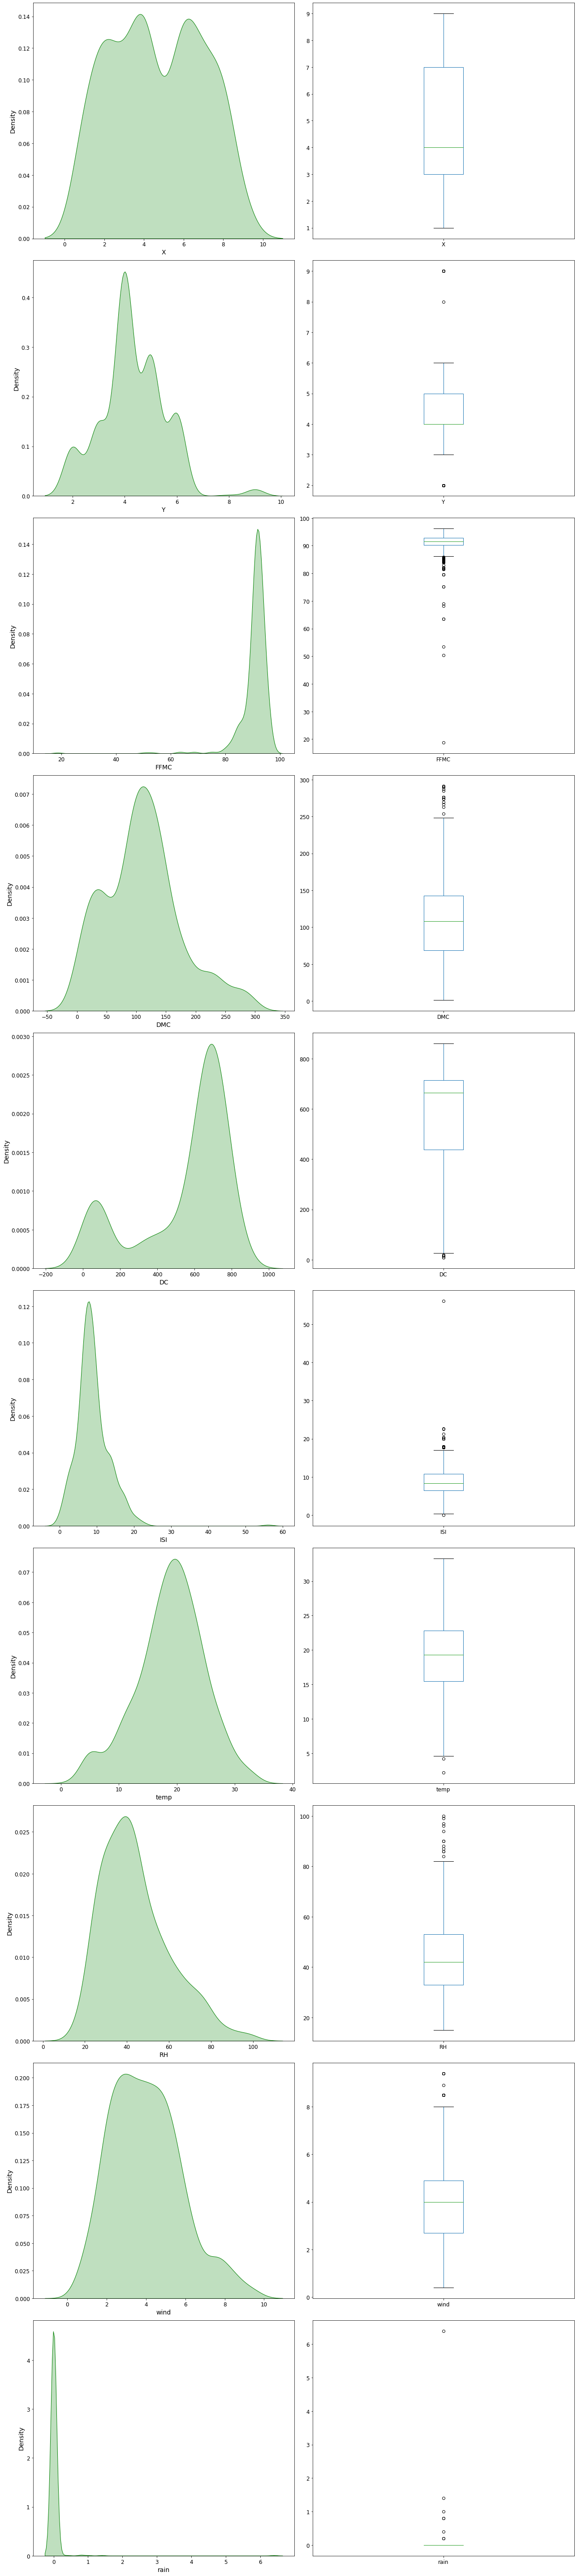

In [26]:
#continous cols
import warnings
warnings.filterwarnings("ignore")
num_cols = ['X','Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
             'rain']
df_pd = df.select(num_cols).toPandas()
plt.figure(figsize=(18,80))
for i,col in enumerate(num_cols,1):
    plt.subplot(10,2,i*2-1)
#     ax.title(col)
    sns.kdeplot(df_pd[col],color='g',shade=True)
    plt.subplot(10,2,i*2)
    df_pd[col].plot.box()
plt.tight_layout() 
plt.show()


In [27]:
stats = df.select([F.skewness(i).alias(i) for i in num_cols])\
        .union(df.select([F.kurtosis(i).alias(i) for i in num_cols]))\
        .toPandas().rename(index = {0:'skewness',1:'kurtosis'})
stats

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036141,0.416085,-6.556512,0.545908,-1.097250,2.528961,-0.330211,0.860398,0.569343,19.758803
kurtosis,-1.172607,1.395269,66.407604,0.191263,-0.254461,21.239490,0.123269,0.422374,0.042217,417.220970


In [28]:
# creating another categorical column with damage
def category (i):
    if i == 0.0:
        return "No damage"
    elif i <= 1:
        return "low"
    elif i <= 25:
        return "moderate"
    elif i <= 100:
        return "high"
    else:
        return "very high"
cat_udf= F.udf(lambda x:category(x),T.StringType())
df = df.withColumn('damage',cat_udf(F.col('area')))

In [29]:
df.limit(5).toPandas()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,no_months,day_no,damage
0,7.0,5.0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,3,6,No damage
1,7.0,4.0,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,10,3,No damage
2,7.0,4.0,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,10,7,No damage
3,8.0,6.0,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,3,6,No damage
4,8.0,6.0,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,3,1,No damage


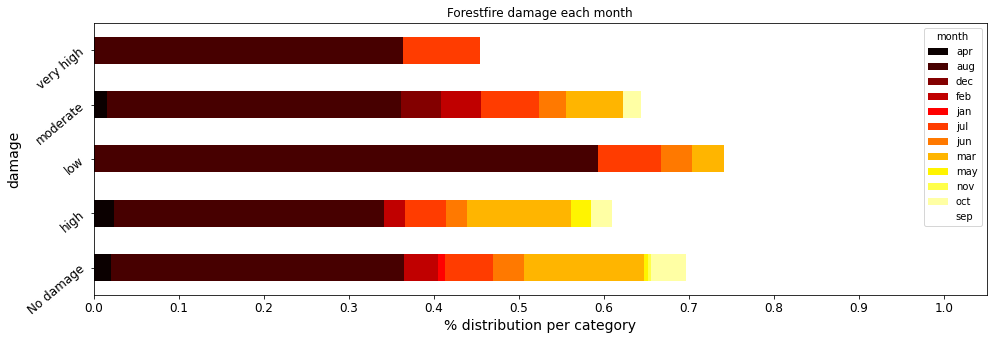

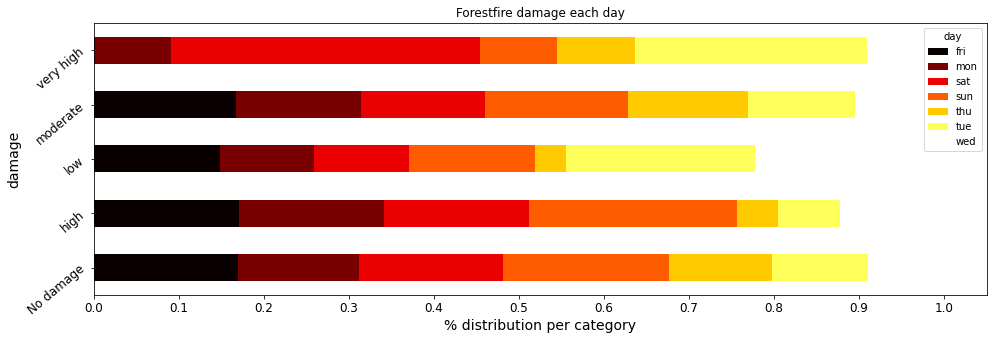

In [30]:
import pandas as pd

cat_cols = ['month', 'day']
df_pd_plot = df.select(['month', 'day','damage']).toPandas()

for col in cat_cols:
    
    cross = pd.crosstab(index=df_pd_plot['damage'],columns=df_pd_plot[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot',figsize=(16,5))
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

# Models

## Linear Regression

In [32]:
# log transformation

from pyspark.sql.functions import col, log

df = df.withColumn("log_area",log(col("area")+1))
df.show(3)

+---+---+-----+---+----+----+-----+---+----+---+----+----+----+---------+------+---------+--------+
|  X|  Y|month|day|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|no_months|day_no|   damage|log_area|
+---+---+-----+---+----+----+-----+---+----+---+----+----+----+---------+------+---------+--------+
|7.0|5.0|  mar|fri|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|        3|     6|No damage|     0.0|
|7.0|4.0|  oct|tue|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|       10|     3|No damage|     0.0|
|7.0|4.0|  oct|sat|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|       10|     7|No damage|     0.0|
+---+---+-----+---+----+----+-----+---+----+---+----+----+----+---------+------+---------+--------+
only showing top 3 rows



+------------------+------------------+
|skewness(log_area)|kurtosis(log_area)|
+------------------+------------------+
| 1.214301426318534|0.9249640699322064|
+------------------+------------------+



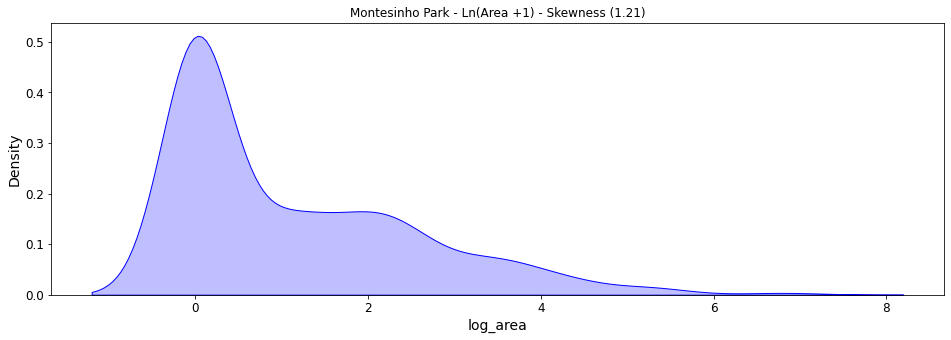

In [33]:
df.select(F.skewness('log_area'),F.kurtosis('log_area')).show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))
ax = sns.kdeplot(df.toPandas()['log_area'],shade=True,color='b')
plt.title('Montesinho Park - Ln(Area +1) - Skewness (1.21)')
plt.show()

In [34]:
# outlier in rain column

df.filter(df.rain >1.5).show()

+---+---+-----+---+----+-----+-----+----+----+---+----+----+-----+---------+------+--------+-----------------+
|  X|  Y|month|day|FFMC|  DMC|   DC| ISI|temp| RH|wind|rain| area|no_months|day_no|  damage|         log_area|
+---+---+-----+---+----+-----+-----+----+----+---+----+----+-----+---------+------+--------+-----------------+
|7.0|5.0|  aug|tue|96.1|181.1|671.2|14.3|27.3| 63| 4.9| 6.4|10.82|        8|     3|moderate|2.469793011977952|
+---+---+-----+---+----+-----+-----+----+----+---+----+----+-----+---------+------+--------+-----------------+



In [35]:
# filter the outlier
df = df.filter(df.rain <=1.5)

In [40]:
# linear regreesion pipe

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.pipeline import Pipeline

predictors = ['temp', 'RH', 'wind', 'rain']

va = VectorAssembler(inputCols= predictors,outputCol='predictors_va')
sc = StandardScaler(inputCol="predictors_va", outputCol="predictors_sc",
                        withStd=True, withMean=True)

pipe_1 = Pipeline(stages=[va,sc]).fit(df)
df_transformed = pipe_1.transform(df)

lr = LinearRegression(featuresCol='predictors_sc',labelCol='log_area')

evaluator_mse = RegressionEvaluator(labelCol='log_area', metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol='log_area', metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol='log_area', metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol='log_area', metricName="r2")

In [41]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# tunning

if enable_grid:
    paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0,2,4])\
    .addGrid(lr.elasticNetParam,[0.0,0.05,0.1])\
    .build()
    crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_mse,
                          numFolds=5)
    cvModel = crossval.fit(df_transformed)

if enable_grid:
    best_model = cvModel.bestModel
    best_reg_param = best_model.getRegParam()
    elastic_net =best_model.getElasticNetParam()
    print(f'best reg param {best_reg_param} best elasticnet param {elastic_net}')

In [42]:
# set parameter and print result

lr.setParams(regParam=2,elasticNetParam=0)

train,test = df_transformed.randomSplit([0.7,0.3], seed=1)

predictions = lr.fit(train).transform(test)

MSE = evaluator_mse.evaluate(predictions)
RMSE = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
R2 = evaluator_r2.evaluate(predictions)

print("Mean Squared Error = " + str(round(MSE,2)))
print("Root Mean Squared Error = " + str(round(RMSE,2)))
print("Mean Absoulute Error = " + str(round(mae,2)))
print("R Squared = " + str(round(R2,2)))

Mean Squared Error = 1.87
Root Mean Squared Error = 1.37
Mean Absoulute Error = 1.14
R Squared = -0.01


In [43]:
# create a pandas dataframe for coefficient and value

coefficients_dict = {'value': list(lr.fit(train).coefficients), 'coefficient':pipe_1.stages[0].getInputCols()}

import pandas as pd

coefficients_df = pd.DataFrame(coefficients_dict)
coefficients_df

,value,coefficient
0,0.036225,temp
1,-0.054103,RH
2,0.020434,wind
3,-0.024195,rain


## decision tree

In [44]:
# decison tree regression

from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='predictors_sc', labelCol='log_area')

# tunning

if enable_grid:
    paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [2,3,4])\
    .addGrid(dt.maxBins,[24,26,28])\
    .addGrid(dt.minInfoGain,[0.04,0.05,0.06])\
    .build()
    crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_mse,
                          numFolds=5)
    cvModel = crossval.fit(df_transformed)

if enable_grid:
    best_model = cvModel.bestModel
    best_dep = best_model.getMaxDepth()
    best_bin =best_model.getMaxBins()
    best_info =best_model.getMinInfoGain()
    print(f'best maxDepth {best_dep} best maxBins {best_bin} best minInfoGain {best_info}')

In [45]:
# set parameter and print result

dt.setParams(maxDepth=2,maxBins=26, minInfoGain =0.05)

train,test = df_transformed.randomSplit([0.7,0.3], seed=1)

predictions = dt.fit(train).transform(test)

MSE = evaluator_mse.evaluate(predictions)
RMSE = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
R2 = evaluator_r2.evaluate(predictions)

print("Mean Squared Error = " + str(round(MSE,2)))
print("Root Mean Squared Error = " + str(round(RMSE,2)))
print("Mean Absoulute Error = " + str(round(mae,2)))
print("R Squared = " + str(round(R2,2)))

Mean Squared Error = 1.87
Root Mean Squared Error = 1.37
Mean Absoulute Error = 1.13
R Squared = -0.01


## gbt

In [46]:
# gbt regression

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol='predictors_sc', labelCol='log_area')

# tunning

if enable_grid:
    paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [2,3,4])\
    .addGrid(gbt.maxBins,[24,26,28])\
    .addGrid(gbt.minInfoGain,[0.04,0.05,0.06])\
    .build()
    crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_mse,
                          numFolds=5)
    cvModel = crossval.fit(df_transformed)

if enable_grid:
    best_model = cvModel.bestModel
    best_dep = best_model.getMaxDepth()
    best_bin =best_model.getMaxBins()
    best_info =best_model.getMinInfoGain()
    print(f'best maxDepth {best_dep} best maxBins {best_bin} best minInfoGain {best_info}')

In [47]:
# set parameter and print result

gbt.setParams(maxDepth=2,maxBins=26, minInfoGain =0.04)

train,test = df_transformed.randomSplit([0.7,0.3], seed=1)

predictions = gbt.fit(train).transform(test)

MSE = evaluator_mse.evaluate(predictions)
RMSE = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
R2 = evaluator_r2.evaluate(predictions)

print("Mean Squared Error = " + str(round(MSE,2)))
print("Root Mean Squared Error = " + str(round(RMSE,2)))
print("Mean Absoulute Error = " + str(round(mae,2)))
print("R Squared = " + str(round(R2,2)))

Mean Squared Error = 1.98
Root Mean Squared Error = 1.41
Mean Absoulute Error = 1.15
R Squared = -0.07
